In [3]:
import os
import cv2
import time
import pandas as pd
import numpy as np
from skimage import feature
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
image = cv2.imread('fer-2013/test/angry/PrivateTest_1623042.jpg', 0)
image.shape

(48, 48)

In [11]:
# Function to read data from folder
def read_data(path: str):
    data_path = []
    labels = []
    for dirname, name, filenames in os.walk('fer-2013/' + path):
        for filename in filenames:
            data_path.append(os.path.join(dirname, filename))
            labels.append(dirname.split('/')[-1])
    return data_path, labels

In [12]:
X_train_path, label_train = read_data('train')
X_test_path, label_test = read_data('test')

In [13]:
df_train = pd.DataFrame(
    {'X_train': X_train_path,
     'y_train' :label_train}
)

In [14]:
df_train.head()

,X_train,y_train
0,fer-2013/train/happy/Training_50449107.jpg,happy
1,fer-2013/train/happy/Training_70433018.jpg,happy
2,fer-2013/train/happy/Training_85610005.jpg,happy
3,fer-2013/train/happy/Training_4460748.jpg,happy
4,fer-2013/train/happy/Training_6312930.jpg,happy


In [18]:
name_train, frequency_train = np.unique(df_train.y_train,return_counts=True)

In [16]:
df_test = pd.DataFrame({
    'X_test':X_test_path,
    'y_test' :label_test}
)

In [17]:
df_test.head()

,X_test,y_test
0,fer-2013/test/happy/PrivateTest_45699463.jpg,happy
1,fer-2013/test/happy/PrivateTest_61855708.jpg,happy
2,fer-2013/test/happy/PublicTest_53681781.jpg,happy
3,fer-2013/test/happy/PrivateTest_52109800.jpg,happy
4,fer-2013/test/happy/PublicTest_41104919.jpg,happy


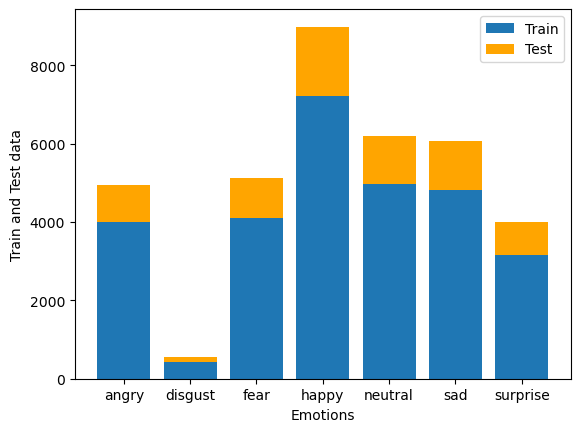

In [24]:
name_test, frequency_test = np.unique(df_test.y_test, return_counts=True)
plt.bar(name_train, frequency_train)
plt.bar(name_test, frequency_test, bottom=frequency_train, color='orange')
plt.xlabel("Emotions")
plt.ylabel("Train and Test data")
plt.legend(["Train", "Test"])

In [25]:
# The above plot shows that the data is unbalanced. The data has many samples for happy but very few for disgust.
# Hence, we need to balance the data.
df_train.y_train.value_counts()

y_train
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64

In [66]:
new_df_train = df_train.loc[:, ]
class_counts = df_train['y_train'].value_counts()
min_count = class_counts.min()

new_df_train = df_train.groupby('y_train').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

In [67]:
# Here we have balanced the data by taking the minimum count of samples for each emotion.
new_df_train.y_train.value_counts()

y_train
angry       436
disgust     436
fear        436
happy       436
neutral     436
sad         436
surprise    436
Name: count, dtype: int64

In [68]:
le = preprocessing.LabelEncoder()
# new_df_train.y_train = le.fit_transform(new_df_train.y_train)

In [69]:
new_df_train.head()

,X_train,y_train
0,fer-2013/train/angry/Training_81438547.jpg,angry
1,fer-2013/train/angry/Training_66014049.jpg,angry
2,fer-2013/train/angry/Training_78759538.jpg,angry
3,fer-2013/train/angry/Training_84548986.jpg,angry
4,fer-2013/train/angry/Training_44947321.jpg,angry


In [49]:
labels = le.inverse_transform(new_df_train.y_train)
print(labels)

['angry' 'angry' 'angry' ... 'surprise' 'surprise' 'surprise']


In [70]:
new_df_test = df_test.loc[:, ]
class_counts = df_test['y_test'].value_counts()
min_count = class_counts.min()

new_df_test = df_test.groupby('y_test').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

In [71]:
new_df_test.y_test.value_counts()

y_test
angry       111
disgust     111
fear        111
happy       111
neutral     111
sad         111
surprise    111
Name: count, dtype: int64

In [72]:
le = preprocessing.LabelEncoder()
# new_df_test.y_test = le.fit_transform(new_df_test.y_test)

In [73]:
new_df_test.head()

,X_test,y_test
0,fer-2013/test/angry/PrivateTest_43530807.jpg,angry
1,fer-2013/test/angry/PrivateTest_2642370.jpg,angry
2,fer-2013/test/angry/PublicTest_80242801.jpg,angry
3,fer-2013/test/angry/PublicTest_96323579.jpg,angry
4,fer-2013/test/angry/PublicTest_48156348.jpg,angry


In [50]:
def extract_HOG_features(X):
    X_train = []
    for i in X:
        img = cv2.imread(i, 0)
        gauss = img
        X_train.append(feature.hog(gauss, orientations=5, pixels_per_cell=(8, 8),
                        cells_per_block=(4, 4), transform_sqrt=True, block_norm="L2"))
    return X_train

In [81]:
y_train = le.fit_transform(new_df_train.y_train)
X_train = extract_HOG_features(new_df_train.X_train)

In [82]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)

In [83]:
y_test = le.fit_transform(new_df_test.y_test)
X_test = extract_HOG_features(new_df_test.X_test)
X_test = scaler.fit_transform(X_test)

In [84]:
X_train[0].shape, X_test[0].shape

((720,), (720,))

In [141]:
models = []
train_accu = []
test_accu = []

def store_results(model, train_acc, test_acc):
    models.append(model)
    train_accu.append(train_acc)
    test_accu.append(test_acc)

def accuracy(model, X, y_true):
    y_pre = model.predict(X)
    return np.sum(y_pre == y_true)/len(y_true)

In [86]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [140]:
# Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=9,random_state=42)
clf7 = DecisionTreeClassifier(max_depth=7,random_state=42)
clf11 = DecisionTreeClassifier(max_depth=11,random_state=42)
clf = clf.fit(X_train, y_train)
clf7 = clf7.fit(X_train, y_train)
clf11 = clf11.fit(X_train, y_train)

In [142]:
y_pred_dt = clf.predict(X_test)
y_pred_dt7 = clf7.predict(X_test)
y_pred_dt11 = clf11.predict(X_test)

In [143]:
store_results(clf, accuracy(clf, X_train, y_train), accuracy(clf, X_test, y_test))
store_results(clf7, accuracy(clf7, X_train, y_train), accuracy(clf7, X_test, y_test))
store_results(clf11, accuracy(clf11, X_train, y_train), accuracy(clf11, X_test, y_test))

In [130]:
# Random Forest Classifier
rf9 = RandomForestClassifier(max_depth=9, random_state=42, criterion='log_loss')
rf9 = rf9.fit(X_train, y_train)

In [131]:
y_pred_rf9 = rf9.predict(X_test)

In [132]:
store_results(rf9, accuracy(rf9, X_train, y_train), accuracy(rf9, X_test, y_test))

In [144]:
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn9 = KNeighborsClassifier(n_neighbors=9)
knn7 = KNeighborsClassifier(n_neighbors=7)
knn5 = KNeighborsClassifier(n_neighbors=5)

knn9 = knn9.fit(X_train, y_train)
knn7 = knn7.fit(X_train, y_train)
knn5 = knn5.fit(X_train, y_train)

In [145]:
y_pred_knn9 = knn9.predict(X_test)
y_pred_knn7 = knn7.predict(X_test)
y_pred_knn5 = knn5.predict(X_test)

In [146]:
store_results(knn9, accuracy(knn9, X_train, y_train), accuracy(knn9, X_test, y_test))
store_results(knn7, accuracy(knn7, X_train, y_train), accuracy(knn7, X_test, y_test))
store_results(knn5, accuracy(knn5, X_train, y_train), accuracy(knn5, X_test, y_test))

In [167]:
result = pd.DataFrame({
    'ML Model': models,
    'Train Accuracy': train_accu,
    'Test Accuracy': test_accu,
})

In [168]:
result

,ML Model,Train Accuracy,Test Accuracy
0,"DecisionTreeClassifier(max_depth=9, random_sta...",0.627130,0.213642
1,"DecisionTreeClassifier(max_depth=7, random_sta...",0.466907,0.234234
2,"DecisionTreeClassifier(max_depth=11, random_st...",0.794561,0.216216
3,KNeighborsClassifier(n_neighbors=9),0.471494,0.334620
4,KNeighborsClassifier(n_neighbors=7),0.499017,0.337194
5,KNeighborsClassifier(),0.541612,0.328185
6,"SVC(C=1, gamma=1, kernel='linear')",0.597313,0.365508
7,"SVC(C=10, gamma=1, kernel='linear')",0.737549,0.339768
8,"SVC(C=100, gamma=1, kernel='linear')",0.930210,0.294723
9,"SVC(C=1000, gamma=1, kernel='linear')",1.000000,0.289575


In [151]:
# Support Vector Machine
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1, gamma=1)
svm1 = SVC(kernel='linear', C=10, gamma=1)
svm2 = SVC(kernel='linear', C=100, gamma=1)
svm3 = SVC(kernel='linear', C=1000, gamma=1)

svm = svm.fit(X_train, y_train)
svm1 = svm1.fit(X_train, y_train)
svm2 = svm2.fit(X_train, y_train)
svm3 = svm3.fit(X_train, y_train)

In [152]:
y_pred_svm = svm.predict(X_test)
y_pred_svm1 = svm1.predict(X_test)
y_pred_svm2 = svm2.predict(X_test)
y_pred_svm3 = svm3.predict(X_test)

In [153]:
store_results(svm, accuracy(svm, X_train, y_train), accuracy(svm, X_test, y_test))
store_results(svm1, accuracy(svm1, X_train, y_train), accuracy(svm1, X_test, y_test))
store_results(svm2, accuracy(svm2, X_train, y_train), accuracy(svm2, X_test, y_test))
store_results(svm3, accuracy(svm3, X_train, y_train), accuracy(svm3, X_test, y_test))

In [156]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

model = SVC()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.37      0.35      0.36       111
           1       0.72      0.55      0.62       111
           2       0.37      0.19      0.25       111
           3       0.58      0.50      0.54       111
           4       0.38      0.48      0.43       111
           5       0.26      0.53      0.35       111
           6       0.72      0.45      0.56       111

    accuracy                           0.44       777
   macro avg       0.49      0.44      0.44       777
weighted avg       0.49      0.44      0.44       777



In [157]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.157 total time=   1.9s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.164 total time=   1.9s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.154 total time=   1.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.166 total time=   1.9s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.166 total time=   1.9s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.291 total time=   1.9s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.313 total time=   1.9s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.333 total time=   1.9s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.330 total time=   1.9s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.315 total time=   1.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.241 total time=   1.9s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [158]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=100, gamma=0.1)


In [159]:
grip_predictions = grid.predict(X_test)

print(classification_report(y_test, grip_predictions))

              precision    recall  f1-score   support

           0       0.39      0.38      0.38       111
           1       0.90      0.68      0.77       111
           2       0.32      0.25      0.28       111
           3       0.60      0.47      0.53       111
           4       0.34      0.43      0.38       111
           5       0.26      0.49      0.34       111
           6       0.83      0.44      0.58       111

    accuracy                           0.45       777
   macro avg       0.52      0.45      0.47       777
weighted avg       0.52      0.45      0.47       777



In [160]:
store_results(grid, accuracy(grid, X_train, y_train), accuracy(grid, X_test, y_test))

In [164]:
best_svm = SVC(C=100, gamma=0.1, kernel='rbf')
best_svm.fit(X_train, y_train)

SVC(C=100, gamma=0.1)

In [165]:
y_pred_best_svm = best_svm.predict(X_test)

In [166]:
store_results(best_svm, accuracy(best_svm, X_train, y_train), accuracy(best_svm, X_test, y_test))

In [171]:
# Best Parameters for Decision Tree Classifier
param_grid = {'max_depth': [3, 5, 7, 9, 11, 13],
            'criterion': ['gini', 'entropy', 'log_loss']}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END .......criterion=gini, max_depth=3;, score=0.264 total time=   0.4s
[CV 2/5] END .......criterion=gini, max_depth=3;, score=0.255 total time=   0.4s
[CV 3/5] END .......criterion=gini, max_depth=3;, score=0.262 total time=   0.4s
[CV 4/5] END .......criterion=gini, max_depth=3;, score=0.279 total time=   0.4s
[CV 5/5] END .......criterion=gini, max_depth=3;, score=0.218 total time=   0.4s
[CV 1/5] END .......criterion=gini, max_depth=5;, score=0.254 total time=   0.6s
[CV 2/5] END .......criterion=gini, max_depth=5;, score=0.250 total time=   0.6s
[CV 3/5] END .......criterion=gini, max_depth=5;, score=0.269 total time=   0.6s
[CV 4/5] END .......criterion=gini, max_depth=5;, score=0.261 total time=   0.6s
[CV 5/5] END .......criterion=gini, max_depth=5;, score=0.238 total time=   0.6s
[CV 1/5] END .......criterion=gini, max_depth=7;, score=0.255 total time=   0.8s
[CV 2/5] END .......criterion=gini, max_depth=7;

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7, 9, 11, 13]},
             verbose=3)

In [172]:
print(grid.best_params_)
print(grid.best_estimator_)

{'criterion': 'gini', 'max_depth': 7}
DecisionTreeClassifier(max_depth=7)


In [173]:
accuracy(grid, X_train, y_train), accuracy(grid, X_test, y_test)

(0.46690694626474444, 0.23037323037323038)

In [174]:
# Best parameter for KNN Classifier
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.336 total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.293 total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.330 total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.295 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.303 total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.349 total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.340 total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.349 total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.320 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.315 total time=   0.0s
[CV

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [175]:
print(grid.best_params_)
print(grid.best_estimator_)

{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
KNeighborsClassifier(weights='distance')


In [176]:
# Best parameter for Random Forest Classifier
param_grid = {'max_depth': [3, 5, 7, 9, 11, 13],
            'criterion': ['gini', 'entropy', 'log_loss']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END .......criterion=gini, max_depth=3;, score=0.318 total time=   1.0s
[CV 2/5] END .......criterion=gini, max_depth=3;, score=0.342 total time=   1.0s
[CV 3/5] END .......criterion=gini, max_depth=3;, score=0.313 total time=   0.9s
[CV 4/5] END .......criterion=gini, max_depth=3;, score=0.352 total time=   1.0s
[CV 5/5] END .......criterion=gini, max_depth=3;, score=0.307 total time=   0.9s
[CV 1/5] END .......criterion=gini, max_depth=5;, score=0.363 total time=   1.4s
[CV 2/5] END .......criterion=gini, max_depth=5;, score=0.352 total time=   1.4s
[CV 3/5] END .......criterion=gini, max_depth=5;, score=0.356 total time=   1.4s
[CV 4/5] END .......criterion=gini, max_depth=5;, score=0.361 total time=   1.4s
[CV 5/5] END .......criterion=gini, max_depth=5;, score=0.338 total time=   1.4s
[CV 1/5] END .......criterion=gini, max_depth=7;, score=0.352 total time=   1.8s
[CV 2/5] END .......criterion=gini, max_depth=7;

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7, 9, 11, 13]},
             verbose=3)

In [177]:
print(grid.best_params_)
print(grid.best_estimator_)

{'criterion': 'log_loss', 'max_depth': 13}
RandomForestClassifier(criterion='log_loss', max_depth=13)


In [178]:
accuracy(grid, X_train, y_train), accuracy(grid, X_test, y_test)

(1.0, 0.4041184041184041)

In [179]:
result = pd.DataFrame({
    'ML Model': models,
    'Train Accuracy': train_accu,
    'Test Accuracy': test_accu,
})

In [180]:
result

,ML Model,Train Accuracy,Test Accuracy
0,"DecisionTreeClassifier(max_depth=9, random_sta...",0.627130,0.213642
1,"DecisionTreeClassifier(max_depth=7, random_sta...",0.466907,0.234234
2,"DecisionTreeClassifier(max_depth=11, random_st...",0.794561,0.216216
3,KNeighborsClassifier(n_neighbors=9),0.471494,0.334620
4,KNeighborsClassifier(n_neighbors=7),0.499017,0.337194
5,KNeighborsClassifier(),0.541612,0.328185
6,"SVC(C=1, gamma=1, kernel='linear')",0.597313,0.365508
7,"SVC(C=10, gamma=1, kernel='linear')",0.737549,0.339768
8,"SVC(C=100, gamma=1, kernel='linear')",0.930210,0.294723
9,"SVC(C=1000, gamma=1, kernel='linear')",1.000000,0.289575


In [187]:
result.to_html('result.html')